In [76]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

# Uniswap Impermanent loss

### Моя статья на Medium:
https://medium.com/@kirill.bogomolov95/uniswap-v2-v3-impermanent-loss-e6b47183033a

В этой статье я расскажу что такое Uniswap Impermanent Loss, и почему это такая острая тема для провайдеров ликвидности.

Более конкретно, что вас ждёт в статье:
- Небольшое погружение в то как работает Uniswap V2
- Impermanent Loss для Uniswap V2
- Погружение в то как работает Uniswap V3
- Impermanent Loss для Uniswap V3
- Проблемы провайдеров ликвидности или почему эта тема очень важна для них


## Небольшое погружение в то как работает Uniswap V2

Uniswap - децентрализованная биржа, на которой можно обменять одни токены на другие. Там нету заявок на покупку или на продажу, а цена определяется формульно:
$$x \cdot y = k$$
$x$ - количество токенов первого типа в пуле <br/>
$y$ - количество токенов второго типа в пуле <br/>
$k$ - константа, задающаяся начальными условиями: произведение кол-в токенов в момент времени перед обменом

Пусть в какой-то момент времени в пуле было монет $x$ и $y$, и пусть какой-то человек хочет купить токены второго типа ($\Delta y$), за токены первого типа в размере $\Delta x$. Тогда происходит следующее. 


В пуле теперь $(x+\Delta x)$ токенов, константа гиперболы та же, поэтому выполняется

$$(x + \Delta x)\cdot (y - \Delta y) = k = x \cdot y$$

Отсюда находим $\Delta y$ - сколько токенов он получит за отданные $\Delta x$


Токены второго типа стали дороже. Цена, по которой произошел обмен: $P = \frac{\Delta y}{\Delta x}$ (либо перевернуть дробь, если хотим измерить в другой монете)






#### Откуда берется ликвидность в этих пулах? 
Есть другая часть пользователей, которая предоставляет ликвидность в такие пулы - провайдеры ликвидности. Они кладут свои токены в эти пулы, и получают комиссии за каждый обмен токенов в этом пуле. Например, при свопе, описанном выше, сначала берется комиссия, и только потом происходит обмен токенов.

Комиссия за обмен распределяется между провайдерами ликвидности в соответствии с вкладом токенов в этот пул.


После обмена общее количество токенов первого типа выросло, а второго - уменьшилось, соответственно у провайдеров ликвидности соотношение кол-ва токенов, которое у них лежит в пуле, тоже поменялось.

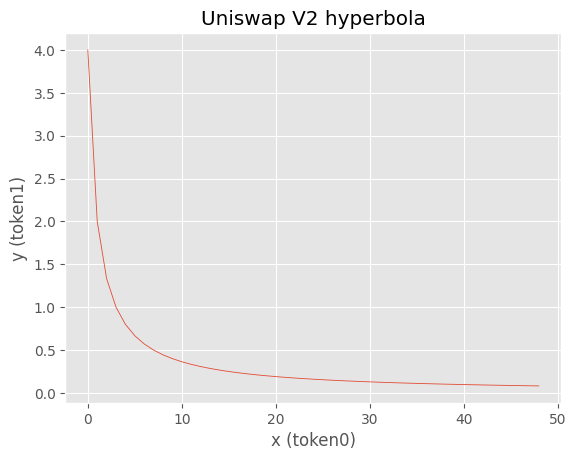

In [151]:
def uniswap_v2_hyperbola(x, L):
    return L**2 / x

L = 2
uni_v2_hyp = [uniswap_v2_hyperbola(x, L) for x in range(1, 50)]

plt.plot(uni_v2_hyp)
plt.title('Uniswap V2 hyperbola')
plt.xlabel('x (token0)')
plt.ylabel('y (token1)')
plt.show()

## Impermanent Loss (для Uniswap V2)

Когда другой пользователь произвел обмен токенов, цена одного токена к другому поменялась. Также поменялось и общее соотношение количества токенов в пуле и соотношение у каждого провайдера ликвидности.
Количество токенов, которые стали стоить дороже, уменьшилось, а тех что стали стоить дешевле - увеличилось.

В итоге суммарная стоимость активов у каждого провайдера ликвидности поменялась.

$$x \cdot y = L^2 $$

$$x = \frac{L^2}{y}$$

$$y = \frac{L^2}{x}$$

$$d(x \cdot y) = xdy + ydx= d(L^2) = 0 => xdy = - ydx => \frac{dy}{dx} = - \frac{y}{x}$$

Один дифференциал обычно считаем положительным, второй - отрицательным, получим 

$$P = \frac{dy}{dx} = \frac{y}{x}$$

$P$ - цена одного токена, выраженная во втором токене

$$y = L \cdot \sqrt{P}$$

$$x = \frac{L}{\sqrt{P}}$$

**Выведем формулу для Impermanent Loss Uniswap V2:**

Суммарная стоимость активов в зависимости от цены:

$$V = y \cdot 1 + x \cdot P = 2 \cdot L \cdot \sqrt{P}$$

Пусть в начальный момент времени юзер планирует положить в Uniswap V2 токены в количествах $x_0$, $y_0$. В начальный момент времени суммарная стоимость этих токенов равна:

$$V_0 = y_0 \cdot 1 + x_0 \cdot P_0 = 2 \cdot L \cdot \sqrt{P_0}$$


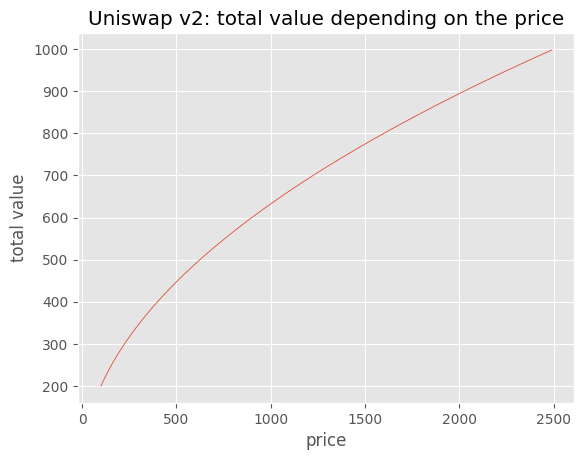

In [74]:
def uniswap_v2_total_value(price, liquidity):
    return 2 * liquidity * (price ** 0.5)

prices = [price for price in range(100, 2500, 10)]

liquidity = 10

tvs = [uniswap_v2_total_value(price, liquidity) for price in prices]

plt.plot(prices, tvs)
plt.xlabel('price')
plt.ylabel('total value')
plt.title('Uniswap v2: total value depending on the price')
plt.show()

Если бы человек не клал токены в юнисвоп, а просто "холдил" бы их, его суммарное портфолио в зависимости от цены:

$$V_{held} = y_0 \cdot 1 + x_0 \cdot P = L \cdot \sqrt{P_0} + \frac{L}{\sqrt{P_0}} \cdot P$$

Для упрощения формул, положим $P = P_0 \cdot k$, $k > 0$

$$V_{held} = L \cdot \sqrt{P_0} \cdot (1 + k)$$

$$IL = \frac{V - V_{held}}{V_{held}} = \frac{L \sqrt{P_0} \cdot (2\sqrt{k} - (1+k))}{L\sqrt{P_0} \cdot (1+k)} = \frac{2\sqrt{k}}{1+k} - 1$$


То есть таким образом можно смотреть, насколько юзер в минусе / плюсе по сравнению с тем, как если бы он не клал токены в uniswap, а просто пассивно бы их держал на кошельке. <br/>



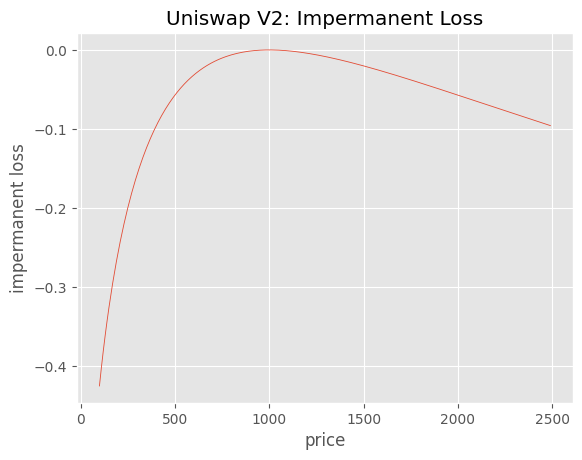

In [144]:
def uniswap_v2_impermanent_loss(k):
    return 2 * (k**0.5) / (k+1) - 1

prices = [price for price in range(100, 2500, 10)]
price0 = 1000

uniswap_v2_ils = [uniswap_v2_impermanent_loss(price / price0) for price in prices]

plt.plot(prices, uniswap_v2_ils)
plt.xlabel('price')
plt.ylabel('impermanent loss')
plt.title('Uniswap V2: Impermanent Loss')
plt.show()

<br/>

#### Иногда Impermanent Loss называют просто зависимостью суммарной стоимости позиции от цены, потому что не всегда интересно сравнивать только с позицией холда токенов в изначальной пропорции.

<br/>

## Небольшое погружение в то как работает Uniswap V3

#### Важно:
Я здесь специально опускаю некоторые детали, связанные с устройством Uniswap V3 (например активация лишь некоторых price ticks, разное кол-во decimals у разных токенов, etc) так как в данном случае они не сильно влияют на результат, но усложняют статью.

В случае Uniswap V3 провайдеры ликвидности могут выбирать, в каком ценовом диапазоне будут использоваться их токены. Таким образом, предоставляемая ликвидность распределяется равномерно не на весь диапазон $[0, +\inf)$, а равномерно в отрезке $[p_a, p_b]$, <br/> $p_a$ - нижняя, $p_b$ - верхняя выставленная цена.

Это выгодно тем, что теперь, выставляя более узкий ценовой диапазон, доля юзера в ликвидности на конкретной цене (на конкретном 'price tick') становится больше, поэтому комиссий он заработает больше. Однако увеличивается и Impermanent Loss, который испытывает его позиция.

Идея аналогична с Uniswap V2. При обмене первого токена на второй так же прибавляется $\Delta x$, и убавляется $\Delta y$.




В случае Uniswap V3 уже гипербола немного другая: приспустившись, она уже пересекает оси Ox и Oy.

$$(x + \frac{L}{\sqrt{P_b}}) \cdot (y + L \cdot \sqrt{P_a}) = L^2$$



Если сделаем замену переменных, можем привести эту гиперболу к привычному виду:



\begin{cases}
    x_{virtual} \cdot y_{virtual} = L^2, \newline
    \newline
    x + \frac{L}{\sqrt{P_b}} \geq 0, \newline
    \newline
    y + L \cdot \sqrt{P_a} \geq 0
\end{cases}

В **случае когда выполняются неравенства**, юнисвоп позиция находится в активном состоянии и генерирует комиссии.

Соответственно будут работать выведенные выше формулы, связывающие кол-во токенов, ликвидность и текущую цену (формулы из Uni V2):

$$y_{virtual} = L \cdot \sqrt{P}$$

$$x_{virtual} = \frac{L}{\sqrt{P}}$$

Теперь выразим $x$, $y$:

$$y = y_{virtual} - L \cdot \sqrt{P_a} = L(\sqrt{P} - \sqrt{P_a})$$

$$x = x_{virtual} - \frac{L}{\sqrt{P_b}} = L(\frac{1}{\sqrt{P}} - \frac{1}{\sqrt{P_b}})$$


Когда цена становится равной $P_b$, ликвидность юзера уже не участвует с обменах и не получает комиссии. Также теперь у него 0% токенов первого (цена которых поднялась) типа и 100% токенов второго типа.
Аналогично с тем, когда цена упала до $P_a$. Тогда у юзера теперь становится 100% первого (обесценившегося) токена и 0% второго токена и ликвидность снова не участвует обменах.

Зануляя либо $x$ либо $y$, можем найти точное количество токенов оставшегося типа.





$$(x + \frac{L}{\sqrt{P_b}})\cdot(y + L \sqrt{P_a}) = L^2$$

#### Количество токенов, когда цена поднялась выше верхней цены:

$P = P_b => x = \frac{L}{\sqrt{P}} - \frac{L}{\sqrt{P_b}} = 0$

$P = P_b => y^* = L\sqrt{P} - L\sqrt{P_a} =  L\sqrt{P_b} - L\sqrt{P_a}$

$y^* = L\sqrt{P_b} - L\sqrt{P_a}$

#### Количество токенов, когда цена опустилась ниже нижней цены:

$P = P_a => y = 0$

$P = P_a => x^* = \frac{L}{\sqrt{P}} - \frac{L}{\sqrt{P_b}}$

$x^* = \frac{L}{\sqrt{P_a}} - \frac{L}{\sqrt{P_b}}$


$$$$

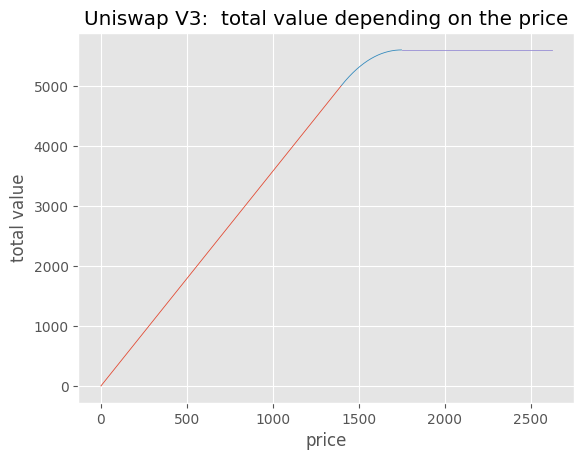

In [141]:
def get_liquidity_from_token0(x0, p0, pb):
    """
        This function returns liquidity from token0 amount
    """
    return x0 / (1 / (p0)**0.5 - 1 / (pb)**0.5)

def get_token1_amount_from_upper_price(L, pa, pb):
    """
        This function returns the amount of token1 when price crosses upper price
    """
    return L * (pb**0.5 - pa**0.5)

def get_token0_amount_from_lower_price(L, pa, pb):
    """
        This function returns the amount of token0 when price drops lower than lower price
    """
    return L * (1 / (pa**0.5) - 1 / (pb**0.5))


def uniswap_v3_total_value(k, L, p0, pa, pb):
    """
        This function returns the total value of uniswap v3 position depending on price and position params
    """
    
    if p0*k >= pa and p0*k <= pb:
        return 2 * L * (p0*k) ** 0.5 - L * ((pa)**0.5 + (p0 * k) / ((pb) ** 0.5))
    
    elif p0*k > pb:
        return get_token1_amount_from_upper_price(L, pa, pb)
        
    elif p0*k < pa:
        return get_token0_amount_from_lower_price(L, pa, pb) * p0 * k
    

prices = [price for price in range(0, 2500, 10)]
price0 = 1640
pa = 1400
pb = 1750
x0 = 1 # e.g. ethers

liquidity = get_liquidity_from_token0(x0, price0, pb)


lower_prices = [price for price in range(0, pa)]

uniswap_v3_tvs_lower_prices = [uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in lower_prices]

intermedate_prices = [price for price in range(pa, pb)]

uniswap_v3_tvs_intermediate_prices = [uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in intermedate_prices]

upper_prices = [price for price in range(pb, int(1.5 * pb))]

uniswap_v3_tvs_upper_prices = [uniswap_v3_total_value(k=price / price0, 
                                                  L=liquidity, 
                                                  p0=price0, 
                                                  pa=pa, 
                                                  pb=pb) for price in upper_prices]


plt.plot(lower_prices, uniswap_v3_tvs_lower_prices, '')
plt.plot(intermedate_prices, uniswap_v3_tvs_intermediate_prices, '')
plt.plot(upper_prices, uniswap_v3_tvs_upper_prices, '')


plt.xlabel('price')
plt.ylabel('total value')
plt.title('Uniswap V3:  total value depending on the price')
plt.show()


## Impermanent Loss (для Uniswap V3)

Аналогично выводу IL для Uniswap V2, запишем полную стоимость позиции в зависимости от цены:

$$V = y\cdot 1 + x \cdot P = L(\sqrt{P} - \sqrt{P_a}) + L(\sqrt{P} - \frac{P}{\sqrt{P_b}})$$

Пусть как прежде $P = P_0 \cdot k$


$$V(P) = 2L\sqrt{P} - L(\sqrt{P_a} + \frac{P}{\sqrt{P_b}})$$

$$V(k) = 2L\sqrt{P_0 \cdot k} - L(\sqrt{P_a} + \frac{P_0 \cdot k}{\sqrt{P_b}})$$

Если бы юзер не открывал юнисвоп позицию, а просто холдил в том же соотношении как в начальный момент времени:

$$V_{held} = y_0 + x_0 \cdot P = L(\sqrt{P_0} - \sqrt{P_a}) + L P_0 k (\frac{1}{\sqrt{P_0}} - \frac{1}{\sqrt{P_b}})$$

$$V_{held} = L\sqrt{P_0}(1+k) - L(\sqrt{P_a} + \frac{P_0 \cdot k}{\sqrt{P_b}})$$

##### Impermanent loss:

$$IL = \frac{V(P) - V_{held}}{V_{held}}$$


$$IL = \frac{2L\sqrt{P_0 \cdot k} - L\sqrt{P_0}(1+k)}{L\sqrt{P_0}(1+k) - L(\sqrt{P_a} + \frac{P_0 \cdot k}{\sqrt{P_b}})}$$

Немного упростим
$$IL(k) = \frac{2\sqrt{k} - 1 - k}{1 + k - \sqrt{\frac{P_a}{P_0}} - k\sqrt{\frac{P_0}{P_b}}}$$

Эта формула справедлива при выполнении неравенств, которые я писал чуть выше. На всякий случай продублирую ещё раз.

\begin{cases}
    x + \frac{L}{\sqrt{P_b}} \geq 0, \newline
    \newline
    y + L \cdot \sqrt{P_a} \geq 0
\end{cases}


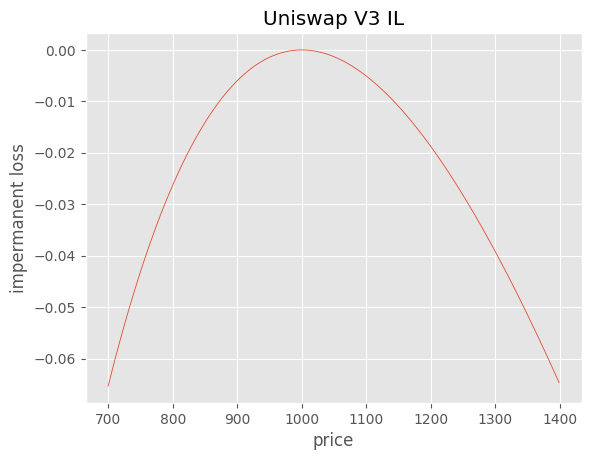

In [143]:
def uniswap_v3_impermanent_loss(k, p0, pa, pb):
    numerator = 2 * (k)**0.5 - 1 - k
    denominator = 1 + k - (pa / p0) - k * (p0 / pb) ** 0.5
    return numerator / denominator

price0 = 1000
pa = 700
pb = 1400
prices = [price for price in range(pa, pb)]


uniswap_v3_ils = [uniswap_v3_impermanent_loss(k=price / price0, p0=price0, pa=pa, pb=pb) for price in prices]

plt.plot(prices, uniswap_v3_ils)
plt.xlabel('price')
plt.ylabel('impermanent loss')
plt.title('Uniswap V3 IL')
plt.show()

### Проблемы провайдеров ликвидности

Теперь рассмотрим риск-профиль юзера, положившего ликвидность в Uniswap V3.
Риск-профиль - в данном случае зависимость суммарной стоимости позиции от цены.
При сильных падениях цены, во-первых, у юзера будет всё больше и больше дешевеющих токенов, соответственно он будет терять денег всё больше и больше - то есть можно сказать что у него **незащищенный риск, связанный с ценой базового актива**.

Юзеру вероятно хотелось бы быть менее зависимым от цены на базовый актив (e.g. цены на эфир, если это пара "eth-usdc"), и при этом всё ещё зарабатывать комиссии как провайдер ликвидности.

### Что он может сделать?

Он может **захеджировать** (=защититься от риска) свою позицию. 

А как это можно сделать - расскажу в следующих статьях.



---

#### Спасибо что дочитали до конца:)


##### Мой twitter:
https://twitter.com/kirrya95

##### Мой telegram:
https://t.me/kirr_ya